# Analyze the results of the prediction
1. Generate the metadataset by running all cells in `create-metadataset.ipynb`
2. Run `train.py`. Make sure to use a config with the postprocessing step `VisualizationBlock`
3. Find the directory in `outputs/` that was created at the time you ran `train.py` and copy the path
4. Paste the path in the `RESULTS_PATH` variable below
5. View the plots, explore the tabels in your IDE, and view the images with the dashboard using their `tile_id`

In [57]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
RESULTS_PATH = Path('../outputs/2024-01-17/14-33-08/results.csv')

In [59]:
# Load the processed metadataset
metadataset = pd.read_csv('../data/processed/metadata.csv', index_col=0)
metadataset

,cloud,land,missing_landsat,kelp,in_train
tile_id,,,,,
JW725114,0.008294,0.142604,0.000000,0.000082,True
UX493605,0.004155,0.303135,0.000000,0.007404,True
OU500661,0.039673,0.254376,0.000000,0.000000,True
DC227980,0.009371,0.429110,0.000000,0.000000,True
SS602790,0.061763,0.837020,0.000000,0.000000,True
...,...,...,...,...,...
UT495238,0.297796,0.601306,0.296580,NaN,False
GE987629,0.307053,0.125967,0.307020,NaN,False
EN974536,0.348498,0.714710,0.348269,NaN,False


Load prediction results csv to analyze performance

In [60]:
# Load the prediction results
results = pd.read_csv(RESULTS_PATH, index_col=0)
results

,sum_targets,sum_preds,intersections,dice_coef
image_key,,,,
AB417661,0,25348.595703,0.000000,0.000000
AD125151,0,-190639.875000,0.000000,-0.000000
AH540191,0,26756.070312,0.000000,0.000000
AI270757,0,19280.482422,0.000000,0.000000
AA498489,345,30486.707031,54.042187,0.003506
AG705659,1149,45786.222656,216.192764,0.009212
AF191061,1632,40367.937500,364.410583,0.017353


Join the results with the metadata

In [61]:
results = results.join(metadataset)
results

,sum_targets,sum_preds,intersections,dice_coef,cloud,land,missing_landsat,kelp,in_train
image_key,,,,,,,,,
AB417661,0,25348.595703,0.000000,0.000000,0.019763,0.000000,0.000000,0.000000,True
AD125151,0,-190639.875000,0.000000,-0.000000,0.097967,0.000000,0.000000,0.000000,True
AH540191,0,26756.070312,0.000000,0.000000,0.006457,0.081616,0.000424,0.000000,True
AI270757,0,19280.482422,0.000000,0.000000,0.025037,0.000000,0.025037,0.000000,True
AA498489,345,30486.707031,54.042187,0.003506,0.000057,0.279241,0.000000,0.002816,True
AG705659,1149,45786.222656,216.192764,0.009212,0.015543,0.606122,0.000000,0.009380,True
AF191061,1632,40367.937500,364.410583,0.017353,0.010245,0.366939,0.000000,0.013322,True


# Compute error
Error is roughly "how much would our score increase if we had perfect predictions for this error"
Lower is better.

In [62]:
# compute error (difference between dice if prediction would've been perfect and actual dice)
total_intersection = results['intersections'].sum()
total_pred_target_sum = results['sum_preds'].sum() + results['sum_targets'].sum()

perfect_dice_coef = (2*results['intersections']+total_intersection) / (2*results['intersections'] + total_pred_target_sum)
actual_dice_coef = (2*results['intersections']+total_intersection) / (results['sum_preds'] + results['sum_targets'] + total_pred_target_sum)
results['error'] = perfect_dice_coef - actual_dice_coef
results

,sum_targets,sum_preds,intersections,dice_coef,cloud,land,missing_landsat,kelp,in_train,error
image_key,,,,,,,,,,
AB417661,0,25348.595703,0.000000,0.000000,0.019763,0.000000,0.000000,0.000000,True,1.214661
AD125151,0,-190639.875000,0.000000,-0.000000,0.097967,0.000000,0.000000,0.000000,True,1.242540
AH540191,0,26756.070312,0.000000,0.000000,0.006457,0.081616,0.000424,0.000000,True,1.215928
AI270757,0,19280.482422,0.000000,0.000000,0.025037,0.000000,0.025037,0.000000,True,1.207137
AA498489,345,30486.707031,54.042187,0.003506,0.000057,0.279241,0.000000,0.002816,True,1.173821
AG705659,1149,45786.222656,216.192764,0.009212,0.015543,0.606122,0.000000,0.009380,True,1.107211
AF191061,1632,40367.937500,364.410583,0.017353,0.010245,0.366939,0.000000,0.013322,True,1.066645


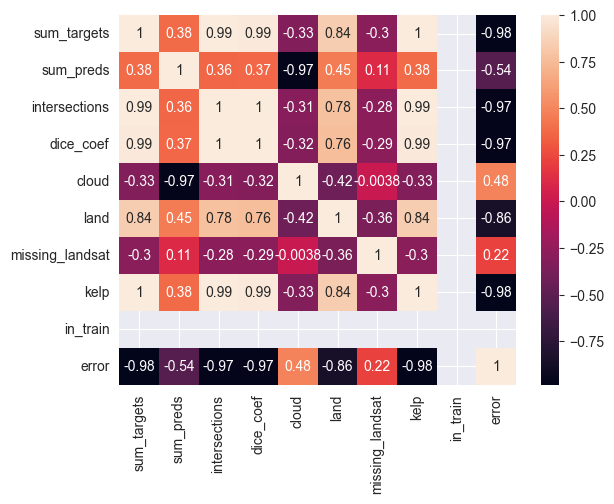

In [63]:
# Plot the correlation matrix with sns
corr = results.corr()
sns.heatmap(corr, annot=True)
plt.show()

# Plots against error

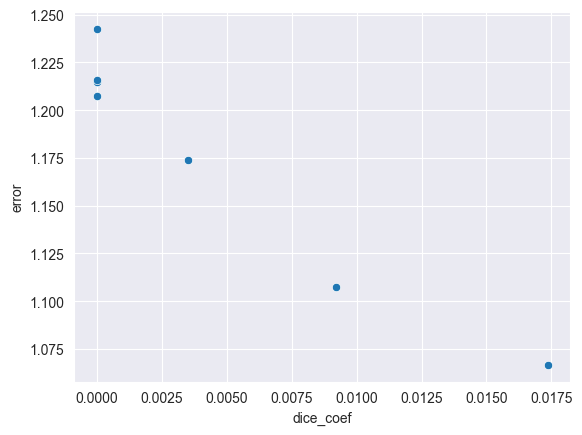

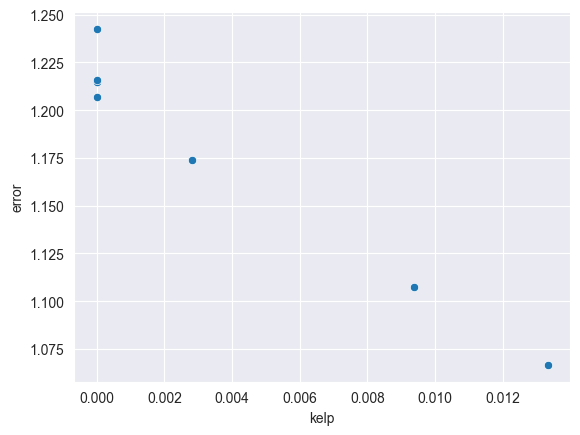

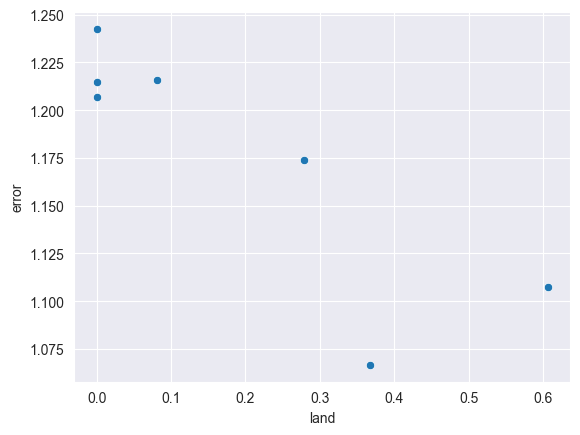

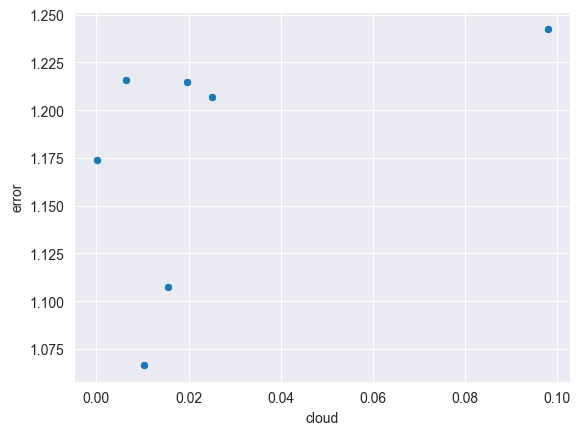

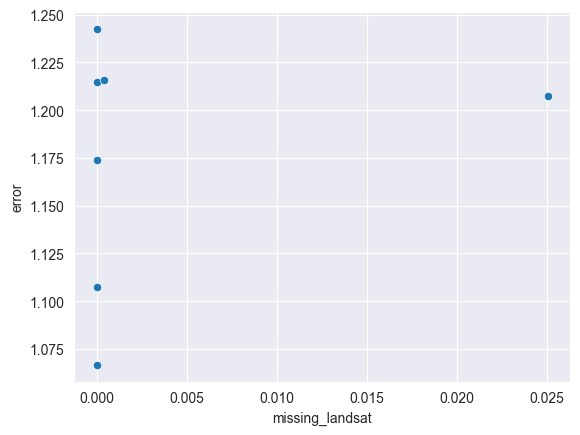

In [64]:
# Plot scatterplots of error
for col in ['dice_coef','kelp', 'land', 'cloud', 'missing_landsat']:
    sns.scatterplot(data=results, x=col, y='error')
    plt.show()

# Plots against dice coef

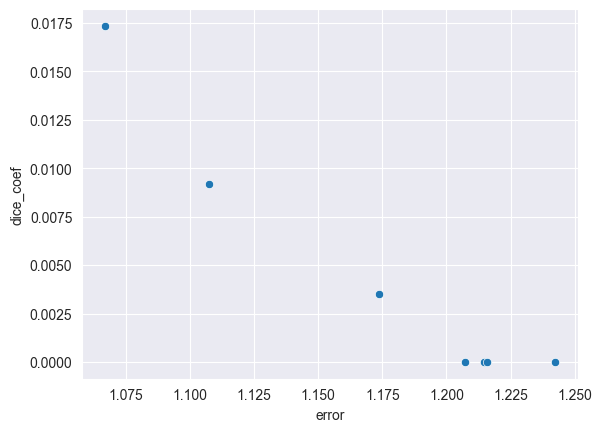

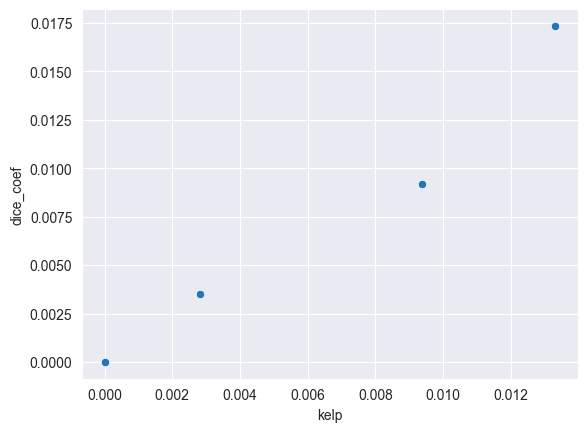

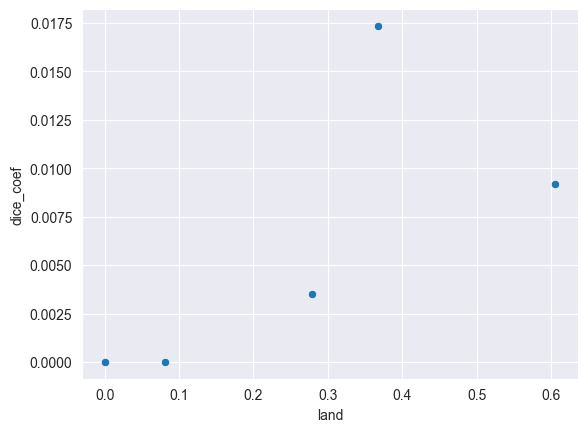

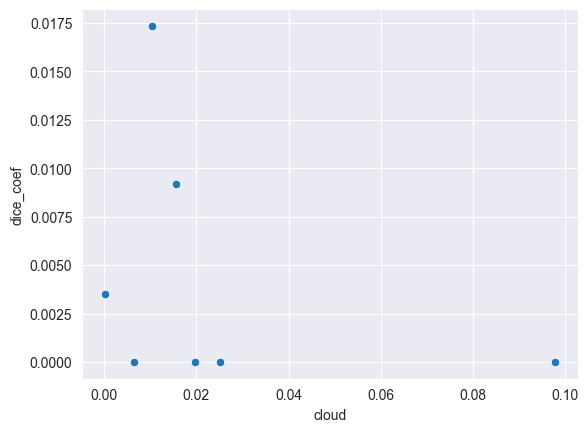

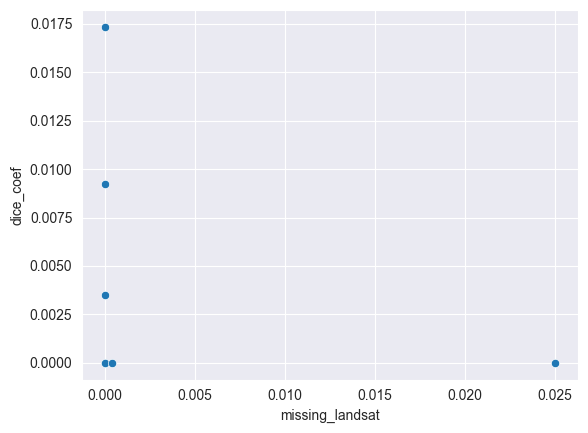

In [65]:
for col in ['error','kelp', 'land', 'cloud', 'missing_landsat']:
    sns.scatterplot(data=results, x=col, y='dice_coef')
    plt.show()

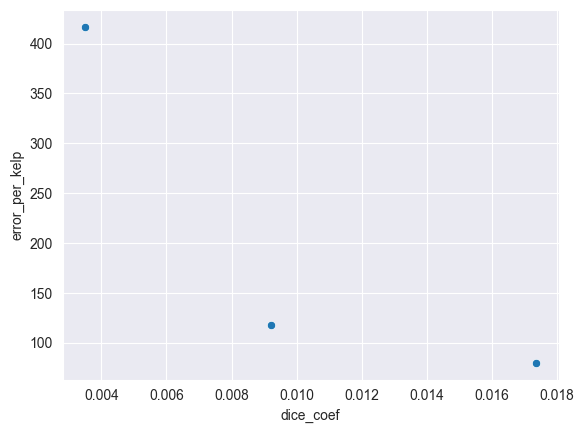

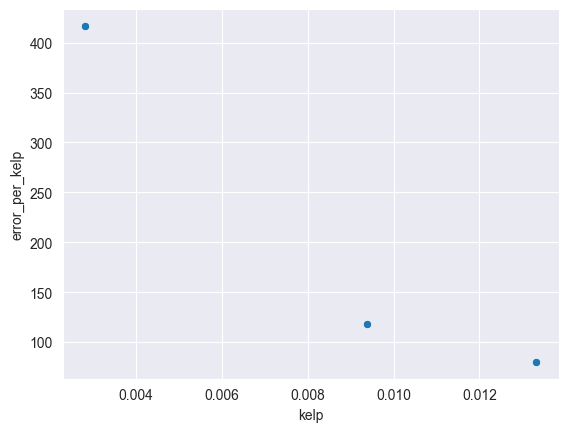

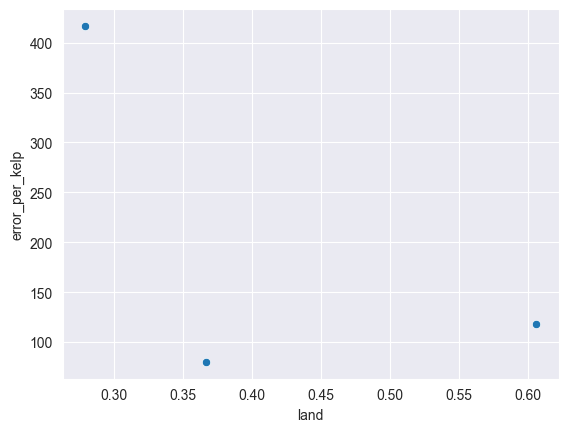

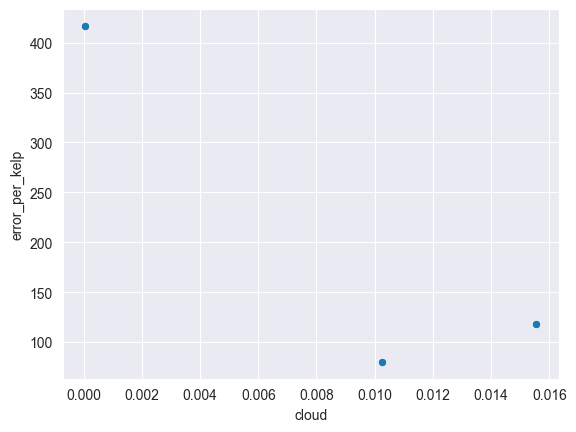

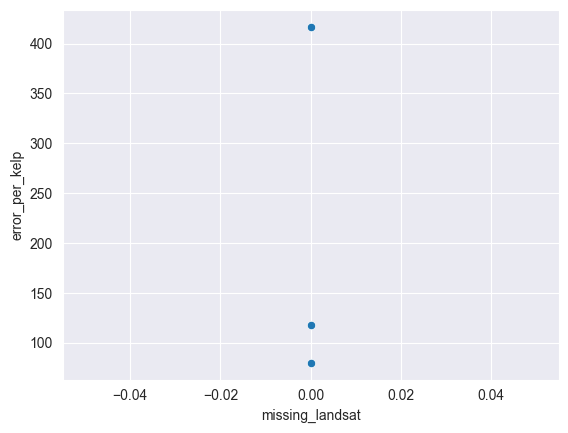

In [66]:
# There is a clear correlation between error and kelp. 
# Create a new column that is the error divided by kelp
# Then make the plots against error again
results['error_per_kelp'] = results['error'] / results['kelp']


# remove outliers with an error_per_kelp larger than n stds
n = 2
results_clean = results[results['kelp'] > 0]
mean = results_clean['error_per_kelp'].mean()
stds = results_clean['error_per_kelp'].std()
results_clean = results_clean[results_clean['error_per_kelp'] < mean + n*stds]


for col in ['dice_coef','kelp', 'land', 'cloud', 'missing_landsat']:
    
    sns.scatterplot(data=results_clean, x=col, y='error_per_kelp')
    plt.show()